# Modeling

General Steps in Modeling

1. Algorithm Selection
2. Fit the models -- turning an algorithm into a model for our specific dataset
    - Linear regression is $y = mx + b$
    - Our model is $\text{final_grade} = 1.3 \times \text{exam1} + 12$
    - we "learn" the coefficients from the training data
3. Predict + Evaluate
4. Repeat
5. Take the best model and use it on the test set to see if we **overfit**

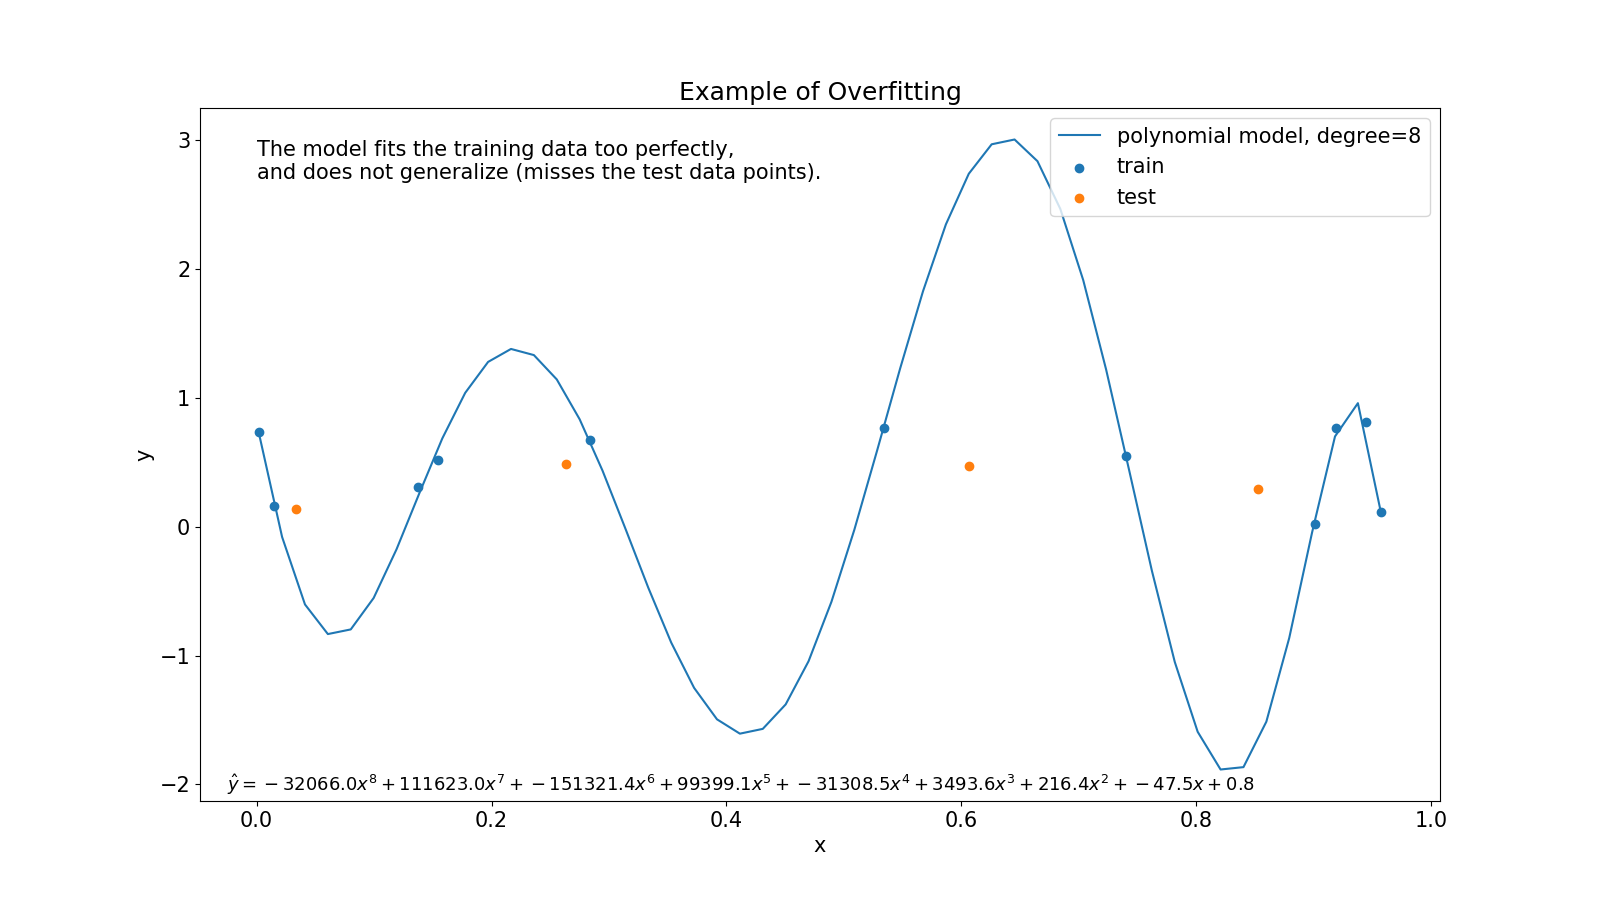

## Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def wrangle_grades():
    '''
    Read student_grades csv file into a pandas DataFrame,
    drop student_id column, replace whitespaces with NaN values,
    drop any rows with Null values, convert all columns to int64,
    return cleaned student grades DataFrame.
    '''
    # Acquire data from csv file.
    file = "https://gist.githubusercontent.com/ryanorsinger/14c8f919920e111f53c6d2c3a3af7e70/raw/07f6e8004fa171638d6d599cfbf0513f6f60b9e8/student_grades.csv"

    grades = pd.read_csv(file)

    # Replace white space values with NaN values.
    grades = grades.replace(r'^\s*$', np.nan, regex=True)

    # Drop all rows with NaN values.
    df = grades.dropna()

    # Convert all columns to int64 data types.
    df = df.astype('int')

    # Perform a train, validate, test split
    train_validate, test = train_test_split(df, random_state=123, train_size=.8)
    train, validate = train_test_split(train_validate, random_state=123, train_size=.7)
    
    return train, validate, test

train, validate, test = wrangle_grades() 

In [ ]:
predictions = pd.DataFrame({
    'actual': validate.final_grade
}) 

In [ ]:
predictions.head()

## Simple Model

$$ y = mx + b $$

$$y = f(x)$$

In [ ]:
from sklearn.linear_model import LinearRegression

# X must be 2-d
X_train = train[['exam1']]
# y can be 1-d
y_train = train.final_grade

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['exam1']]
predictions['simple_lm'] = lm.predict(X_validate)

In [ ]:
predictions.head()

### Examine The Model

- **intercept**: Value we predict if x is 0. Depending on our x variables, this may not be valuable
- **coefficients**: define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a `coef` unit change in y, holding all other independent variables constant

In [ ]:
lm.coef_, lm.intercept_

In [ ]:
print('final_grade = {:.3f} * exam1 + {:.3f}'.format(lm.coef_[0], lm.intercept_))

In [ ]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.exam1, train.final_grade, label='actual')
plt.scatter(train.exam1, lm.predict(train[['exam1']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Exam 1')
plt.ylabel('Final Grade')
plt.legend()

### Model Interpretation

In [ ]:
# final_grade = 0.761 * exam1 + 22.003
print(f'For every 1 point increase in Exam 1, we predict a {lm.coef_[0]:.2f} point increase in Final Grade')

In [ ]:
exam1 = np.arange(90, 96)
final_grade = lm.predict(exam1.reshape(-1, 1))
pd.DataFrame(dict(exam1=exam1, predicted_final_grade=final_grade))

## Multiple Regression + RFE

$$ y = m_1x_1 + m_2x_2 + b $$

$$ y = f(x1, x2, ...) $$

In [ ]:
X_train = train.drop(columns='final_grade')
y_train = train.final_grade
X_validate = validate.drop(columns='final_grade')

lm = LinearRegression()
k = 2

# 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train, y_train)
print('selected top 2 features:', X_train.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train)

In [ ]:
X_train.shape

In [ ]:
X_train_rfe.shape

In [ ]:
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

### Examine the Model

In [ ]:
X_train.columns[rfe.support_]

In [ ]:
lm.coef_, lm.intercept_

In [ ]:
print(f'final_grade = {lm.coef_[0]:.2f} x exam1 + {lm.coef_[1]:.2f} x exam3 + {lm.intercept_:.2f}')

In [ ]:
X = pd.DataFrame({
    'exam1': [80, 81, 82, 83, 84, 85, 85, 85, 85, 85, 85],
    'exam3': [80, 80, 80, 80, 80, 80, 81, 82, 83, 84, 85]
})

X['predicted_final_grade'] = lm.predict(X)
X

## Polynomial Features

First off...what the heck is a polynomial?

$$ y = a_0x^0 + a_1x^1 + a_2x^2 + ... + a_nx^n $$

or a simpler form:

$$ y = a_0 + a_1x + a_2x^2 + ... + a_nx^n $$

`degree = order = n`

What does a polynomial look like when graphed on a coordinate plane? Well it depends on
- The intercept
- The coefficients

Consider this third degree polynomial:

$$ y = 2x + x^3 $$

In [ ]:
x = np.linspace(-10, 10, num=100)
fx = []
for i in range(len(x)):
    fx.append(2*x[i] + x[i]**3) # This could have also been done with list comprehension
    
plt.plot(x, fx)
plt.grid()
plt.axvline(color='black')
plt.axhline(color='black')
plt.show()

Let's try a different combination of intercept and coefficients:

$$ y = 1340 + 1.3x - 12x^2 + 0.5x^3 $$

In [ ]:
x = np.linspace(-10, 10, num=100)
fx = []
for i in range(len(x)):
    fx.append(1340 + 1.3*x[i] - 12*x[i]**2 + 0.5*x[i]**3) # This could have also been done with list comprehension
    
plt.plot(x, fx)
plt.grid()
plt.axvline(color='black')
plt.axhline(color='black')
plt.show()

If trying different intercepts and coefficients can produce a different shape of line, and we are looking for a line that minimizes error when fitting to training data...

Then we can use polynomial regression to make a curvilinear line of best fit! Finding that line of best fit just involves the magic of calculus.

With polynomial regression, we create very similar looking formulas:

$$ y = B_0 + B_1x + e $$

$$ y = B_0 + B_1x + B_2x^2 + e $$

$$ ... $$

$$ y = B_0 + B_1x + ... + B_kx^k + e $$


### Beware the **curse of dimensionality** and **combinatorial explosion**!

|   # Features |   Interaction Terms |   Total Terms (degree=2) |   Total Terms (degree=3) |
|-------------:|--------------------:|-------------------------:|-------------------------:|
|            1 |                   0 |                        2 |                        3 |
|            2 |                   1 |                        5 |                        9 |
|            3 |                   3 |                        9 |                       19 |
|            4 |                   6 |                       14 |                       34 |
|            5 |                  10 |                       20 |                       55 |
|            6 |                  15 |                       27 |                       83 |
|            7 |                  21 |                       35 |                      119 |

- degree = 2, single x
    $$ y = ax^2 + bx + c $$
- degree = 3, single x
    $$ y = ax^3 + bx^2 + cx + d $$
- degree = 2, x0 + x1
    $$ y = x_0^2 + x_0x_1 + x_1^2 + x_0 + x_1 $$

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

X_train = train[['exam1', 'exam2', 'exam3']]
X_validate = validate[['exam1', 'exam2', 'exam3']]
y_train = train.final_grade
y_validate = validate.final_grade

# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
X_train_poly.head()

In [ ]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)

In [ ]:
predictions.head()

Examine the coefficients of the resulting model.

In [ ]:
feature_names = poly.get_feature_names(X_train.columns)
pd.Series(lm.coef_, index=feature_names).sort_values()

Another model with only interaction terms

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train.columns)).sort_values()

In [ ]:
predictions.head()

Takeaway: interaction terms can be useful if you suspect there's a multiplicative relationship between independent variables. Higher order polynomial features should be used with caution (usually when you have domain knowledge that says this is the right thing to do).

Example: Telco churn, using monthly charges and tenure to predict total charges. monthly charges times tenure will give us a good number for total charges.

## Lasso-Lars

Performs intrinsic feature selection and noise reduction to avoid overfitting.

The most important hyperparameter is `alpha`. 
- `alpha` determines the degree of regularization applied to the model. 
- The lowest `alpha` is zero, and this represents no regularization (identical to OLS). 
- There is no limit to `alpha`, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero. 

Generally speaking, the higher the alpha, the lower your risk for overfitting. 

`alpha` = 1.0 is a good place to start.

In [ ]:
from sklearn.linear_model import LassoLars

`alpha = 0`

In [ ]:
# create the model object
lars = LassoLars(alpha=0)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

In [ ]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

`alpha = 0.5`

In [ ]:
# create the model object
lars = LassoLars(alpha=0.5)

# fit the model to our training data= 
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

In [ ]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

`alpha = 1.0`

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_validate_pred_lars

In [ ]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

`alpha = 2`

In [ ]:
# create the model object
lars_high_alpha = LassoLars(alpha=2)

# fit the model to our training data
lars_high_alpha.fit(X_train, y_train)

# predict validate
X_validate_pred_lars_high_alpha = lars.predict(X_validate)

In [ ]:
pd.Series(lars_high_alpha.coef_, index=X_train.columns).sort_values()

In [ ]:
predictions.head()

## Generalized Linear Model

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the `TweedieRegressor` method to create a GLM using sklearn.

> `sklearn.linear_model.TweedieRegressor(power=0, alpha=1.0)`

        power = 0: Normal Distribution
        power = 1: Poisson Distribution
        power = (1,2): Compound Distribution
        power = 2: Gamma Distribution
        power = 3: Inverse Gaussian Distribution

In [ ]:
from sklearn.linear_model import TweedieRegressor

# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train, y_train)

# predict validate
X_validate_predict_glm = glm.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['glm'] = X_validate_predict_glm

In [ ]:
pd.Series(glm.coef_, index=X_train.columns).sort_values()

In [ ]:
glm.intercept_

In [ ]:
predictions.head()

### TL;DR

First of all, it always helps to know the distribution of your target variable before modeling.

> `plt.hist(y_train)` to see the shape of your target (`y`).

Secondly, you could try them all...doesn't hurt usually.

Third, if you have a good feel for your data:
- For a normally distributed y and a linear relationship: OLS, LassoLars, GLM(power=0) will work best.
- For polynomial relationships, polynomial regression is best.
- For poisson, gamma or inverse gaussian distributions, use the Generalized Linear Model.

## Evaluation

In [ ]:
# add a baseline model
predictions['baseline'] = train.final_grade.mean()

In [ ]:
predictions.head()

Calculate mean squared error for every column in the dataframe

In [ ]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

## Evaluate on Test: Best Model (2nd Degree Polynomial)

Notice this gets a bit more complicated as we have to reproduce any transformations to the data we did when training. Polynomial transformations need to be applied to the test dataframe to evaluate the polynomial model. 

In [ ]:
# re-create our polynomial model
X_train = train[['exam1', 'exam2', 'exam3']]
y_train = train.final_grade

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)

lm = LinearRegression()
lm.fit(X_train_poly, y_train)

In [ ]:
# any transformations applied to your training data must be applied to the test as well

X_test = test[['exam1', 'exam2', 'exam3']]
X_test_poly = poly.transform(X_test)

test_predictions = lm.predict(X_test_poly)
test_actual = test.final_grade

In [ ]:
mean_squared_error(test_actual, test_predictions)

## Further Reading

- [sklearn Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)
- [The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) and [Combinatorial Explosion](https://en.wikipedia.org/wiki/Combinatorial_explosion)